<a href="https://colab.research.google.com/github/MarisaRies/covir/blob/main/COVIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [388]:
#Encryption
#!pip install cape_privacy

In [389]:
#Lade Bibliotheken
import sqlite3            as sq
from sqlite3 import Error
import pandas             as pd
import numpy              as np
import requests
import datetime           as dt
import seaborn            as sns
import matplotlib.pyplot  as plt
import matplotlib         as mpl
%matplotlib inline

In [390]:
#Pfad Definitionen
drive_path        = "/content/drive"
project_root_path = f"{drive_path}/MyDrive/Studium/COVIR"
csv_file_path     = f"{project_root_path}/CSV/"
image_path        = f"{project_root_path}/Bilder/"
git_path          = "https://raw.githubusercontent.com/MarisaRies/covir/main/"

In [391]:
#
# Aufbau der Quelldatenbank
#

#Verbinden von GDrive
from google.colab import drive 
drive.mount("/content/drive", force_remount=True)

#Verbindung zu SQLite
def create_connection_memory():
  conn_src = None;
  try:
    #Verbindungsaufbau
    conn_src = sq.connect(':memory:')
    return conn_src
    print(sqlite3.version)
  except Error as e:
    print("Quell-Datenbank: Fehler #1 beim Verbinden zu SQLite", e)

#Lokale Definition der SQLite Verbindung
def create_connection_local(local_path):
  conn_src = None;
  try:
    #Verbindungsaufbau
    conn_src = sq.connect(local_path+'/covir_src.db')
    return conn_src
    print(sqlite3.version)
  except Error as e:
    print("Quell-Datenbank: Fehler #2 beim Verbinden zu SQLite", e) 
conn_src = create_connection_memory()

cur_src = conn_src.cursor()
print("Quell-Datenbank: Verbindung erfolgreich zu SQLite")

#Tabellenschema erzeugen
cur_src.executescript(requests.get(git_path+'sql/1src_db_create_statements.sql').text)

conn_src.commit()

print("Quell-Datenbank: Tabellenschema erfolgreich erstellt")

Mounted at /content/drive
Quell-Datenbank: Verbindung erfolgreich zu SQLite
Quell-Datenbank: Tabellenschema erfolgreich erstellt


In [392]:
#
# ETL-Prozess: Extraktion
#

#CSV-Daten aus Google-Drive in Dateframes laden, relevante Spalten auswählen
df_csv_pat = pd.read_csv(csv_file_path+'patients.csv')
df_csv_pat = df_csv_pat[['Id','BIRTHDATE','DEATHDATE','FIRST','LAST']]

df_csv_enc = pd.read_csv(csv_file_path+'encounters.csv')
df_csv_enc = df_csv_enc[['Id','START','STOP','PATIENT','CODE','DESCRIPTION']]

df_csv_con = pd.read_csv(csv_file_path+'conditions.csv')
df_csv_con = df_csv_con[['ENCOUNTER','START','STOP','PATIENT','CODE','DESCRIPTION']]

df_csv_imm = pd.read_csv(csv_file_path+'immunizations.csv')
df_csv_imm = df_csv_imm[['ENCOUNTER','DATE','PATIENT','CODE','DESCRIPTION']]

#Dataframes in Quell-Datenbank laden
df_csv_pat.to_sql('tb_patients', conn_src, if_exists='append', index=False)
df_csv_enc.to_sql('tb_encounters', conn_src, if_exists='append', index=False)
df_csv_con.to_sql('tb_conditions', conn_src, if_exists='append', index=False)
df_csv_imm.to_sql('tb_immunizations', conn_src, if_exists='append', index=False)

conn_src.commit()

#Dataframes löschen (werden nicht mehr gebraucht)
del(df_csv_pat) 
del(df_csv_enc)
del(df_csv_con)
del(df_csv_imm)

print("ETL-Extraktion: Relevante Daten aus CSV extrahiert und in Quelldatenbank eingefügt")

ETL-Extraktion: Relevante Daten aus CSV extrahiert und in Quelldatenbank eingefügt


In [393]:
#
# ETL-Prozess: Transformation
#

#Tabellenschema für Data-Warehouse aus Quelldatenbank ableiten und temporär in Dataframes speichern
cur_src.execute(
"""
SELECT * 
FROM tb_patients 
"""
)
df_src_pat = pd.DataFrame(cur_src.fetchall(), columns=('Id', 'birthdate', 'deathdate', 'first', 'last'))

cur_src.execute(
"""
SELECT 
  enc.Id,
  enc.start as date, 
  enc.patient,
  enc.code,
  enc.description,
  con.code as action_code,
  con.description as action_desc,
  'con' as action_src
FROM 
  tb_encounters as enc,
  tb_conditions as con
WHERE
(
  con.encounter = enc.Id
)

UNION

SELECT 
  enc.Id,
  enc.start as date, 
  enc.patient,
  enc.code,
  enc.description,
  imm.code as action_code,
  imm.description as action_desc,
  'imm' as action_src
FROM 
  tb_encounters as enc,
  tb_immunizations as imm
WHERE
(
  imm.encounter = enc.Id
);
"""
)
df_src_enc = pd.DataFrame(cur_src.fetchall(), columns=('Id', 'date', 'patient', 'code', 'description', 'action_code','action_desc', 'action_src'))

cur_src.execute(
"""
SELECT DISTINCT 
  code as action_code, 
  description as action_desc 
FROM tb_conditions 

UNION

SELECT DISTINCT 
  code as action_code, 
  description as action_desc 
FROM tb_immunizations 
"""
)
df_src_cod = pd.DataFrame(cur_src.fetchall(), columns=('action_code', 'action_desc'))

print("ETL-Transformation: Schema-Transformation von Quelldatenbank nach Data-Warehouse erfolgreich abgeschlossen")

#Alter berechnen und als neues Feld dem Dataframe für Patienten-Daten hinzufügen
df_src_pat['birthdate'] = pd.to_datetime(df_src_pat['birthdate'], format='%Y-%m-%d') #Daten von String in DateTime umwandeln für spätere Berechnung
df_src_pat['deathdate'] = pd.to_datetime(df_src_pat['deathdate'], format='%Y-%m-%d')

df_src_pat['EOL'] = df_src_pat.deathdate #Temporäre Spalte für Referenzpunkt der Altersberechnung (Todestag oder Heute)
df_src_pat['EOL'] = df_src_pat['EOL'].fillna(pd.to_datetime("today")) #Einsetzen von heutigem Datum, falls kein Todestag bekannt

df_src_pat['age'] =  df_src_pat['EOL'].dt.year - df_src_pat['birthdate'].dt.year #Alter berechnen (Referenztag - Geburtstag) und in neue Spalte 'age' einfügen
df_src_pat = df_src_pat.drop(columns=['EOL']) #Temporäre Spalte wieder löschen

print("ETL-Transformation: Alter berechnet und in Patienten-Tabelle eingefügt")

ETL-Transformation: Schema-Transformation von Quelldatenbank nach Data-Warehouse erfolgreich abgeschlossen
ETL-Transformation: Alter berechnet und in Patienten-Tabelle eingefügt


In [394]:
#
# ETL-Prozess: Laden
#

#Verbindung zu SQLite
def create_connection_memory():
  conn_dwh = None;
  try:
    #Verbindungsaufbau
    conn_dwh = sq.connect(':memory:')
    return conn_dwh
    print(sqlite3.version)
  except Error as e:
    print("ETL-Laden: Fehler #1 beim Verbinden zu SQLite", e)

#Lokale Definition der SQLite Verbindung
def create_connection_local(local_path):
  conn_dwh = None;
  try:
    #Verbindungsaufbau
    conn_dwh = sq.connect(local_path+'/covir_dwh.db')
    return conn_dwh
    print(sqlite3.version)
  except Error as e:
    print("ETL-Laden: Fehler #2 beim Verbinden zu SQLite", e) 
conn_dwh = create_connection_memory()

cur_dwh = conn_dwh.cursor()
print("ETL-Laden: Verbindung erfolgreich zu SQLite")

#Dataframes in Data-Warehouse laden
df_src_pat.to_sql('tb_patients', conn_dwh, if_exists='replace', index=False)
df_src_enc.to_sql('tb_encounters', conn_dwh, if_exists='replace', index=False)
df_src_cod.to_sql('tb_codes', conn_dwh, if_exists='replace', index=False)

conn_dwh.commit()

#Dataframes löschen (werden nicht mehr gebraucht)
del(df_src_pat) 
del(df_src_enc)
del(df_src_cod)

print("ETL-Laden: Dataframes erfolgreich in Data-Warehouse geladen, Data-Warehouse bereit!")

ETL-Laden: Verbindung erfolgreich zu SQLite
ETL-Laden: Dataframes erfolgreich in Data-Warehouse geladen, Data-Warehouse bereit!


In [395]:
#Übersicht Patienten Tabelle
df_dwh_pat = pd.read_sql_query("SELECT * FROM tb_patients", conn_dwh)
df_dwh_pat.info()
df_dwh_pat

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         1050 non-null   object
 1   birthdate  1050 non-null   object
 2   deathdate  50 non-null     object
 3   first      1050 non-null   object
 4   last       1050 non-null   object
 5   age        1050 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 49.3+ KB


Id  ...  age
0     2f114e21-8b95-e9eb-2e9e-4b950b059cfa  ...   20
1     2812f4fc-6aba-0033-728b-7e569bb8adcc  ...   80
2     9b1a203a-6368-49a5-0c79-45c32729bc17  ...    9
3     52a250a9-24e4-ec9b-91d6-c38cf1b10fc0  ...   25
4     ad5525c0-fdab-94dc-018f-d7209c72bdef  ...   57
...                                    ...  ...  ...
1045  edab2899-dac4-a19d-59e2-a9bea7b95cab  ...   23
1046  d1065043-2a5f-2d0e-1dd0-cb7f31e6d340  ...   62
1047  4c523ab1-3255-911a-7eef-3bc3e48b7b05  ...   61
1048  8d49cb05-b1c3-b8fe-dc75-e43ad861f074  ...  100
1049  fce5ed5c-e218-4839-a0c5-6ef906e5ae73  ...  102

[1050 rows x 6 columns]

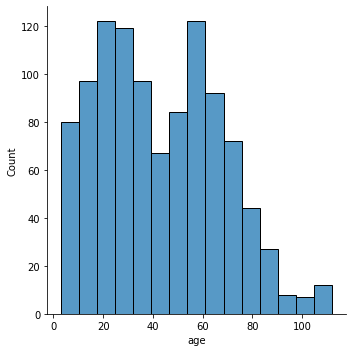

In [396]:
#Grafik Altersverteilung
sns.displot(df_dwh_pat["age"])
plt.savefig(image_path+'Histogramm_Patientenalter.png')
plt.show()

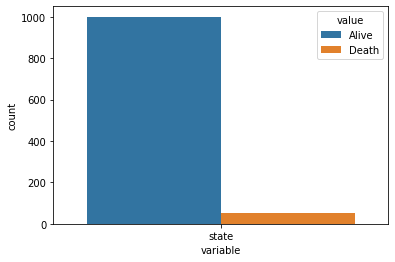

In [397]:
#Grafik Alive vs Death
df_dwh_pat["state"] = df_dwh_pat["deathdate"] #Kopieren der Spalte Todestag in neue Spalte "state"
df_dwh_pat["state"] = df_dwh_pat["state"].fillna('Alive') #Normalisierung von NaN nach 'Alive'
df_dwh_pat["state"] = df_dwh_pat["state"].replace(['[^Alive]'], '', regex = True) #Normalisierung jeder Zeile ungleich 'Alive' nach '' mittels regulärem Ausdruck
df_dwh_pat["state"] = df_dwh_pat["state"].replace([''], 'Death') #Ersetzen von '' mit 'Death'

sns.countplot(x="variable", hue= "value", data=pd.melt(df_dwh_pat[["state"]]))
plt.savefig(image_path+'Histogramm_Lebendig-Tot.png')
plt.show()

In [398]:
#Übersicht Encounter (Begegnung) Tabelle
df_dwh_enc = pd.read_sql_query("SELECT * FROM tb_encounters", conn_dwh)
df_dwh_enc.info()
df_dwh_enc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19500 entries, 0 to 19499
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Id           19500 non-null  object
 1   date         19500 non-null  object
 2   patient      19500 non-null  object
 3   code         19500 non-null  object
 4   description  19500 non-null  object
 5   action_code  19500 non-null  object
 6   action_desc  19500 non-null  object
 7   action_src   19500 non-null  object
dtypes: object(8)
memory usage: 1.2+ MB


Id  ... action_src
0      00009d66-b01e-da8a-2568-a2544e9fcd95  ...        imm
1      0003495f-5d93-2faf-6301-ec3ec5a60198  ...        imm
2      0003495f-5d93-2faf-6301-ec3ec5a60198  ...        imm
3      0003495f-5d93-2faf-6301-ec3ec5a60198  ...        imm
4      0003495f-5d93-2faf-6301-ec3ec5a60198  ...        imm
...                                     ...  ...        ...
19495  fff70f86-6d30-cf4a-6b28-86969106b262  ...        con
19496  fff70f86-6d30-cf4a-6b28-86969106b262  ...        con
19497  fff70f86-6d30-cf4a-6b28-86969106b262  ...        con
19498  fff70f86-6d30-cf4a-6b28-86969106b262  ...        con
19499  ffffb8f3-10ec-8e7f-5c27-6f928c182cbb  ...        imm

[19500 rows x 8 columns]

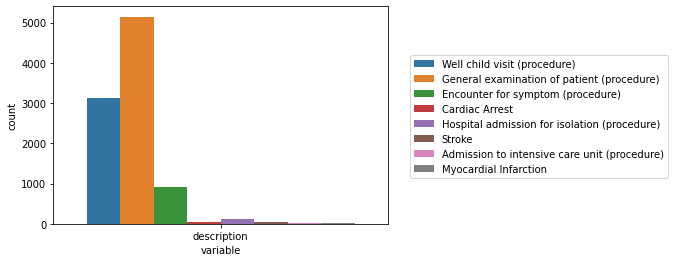

In [399]:
#Grafik Verteilung der Begenungsgründe
df_dwh_enc_dis = pd.read_sql_query("SELECT DISTINCT Id, date, patient, code, description FROM tb_encounters", conn_dwh)
sns.countplot(x="variable", hue= "value", data=pd.melt(df_dwh_enc_dis[["description"]]))
plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), ncol=1)
plt.savefig(image_path+'Histogramm_Begegnungsgrund.png')
plt.show()

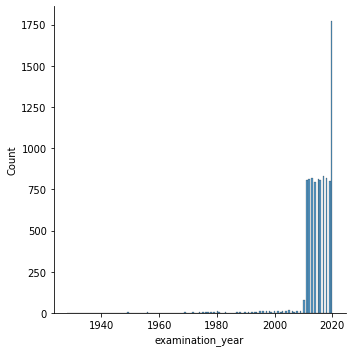

In [400]:
#Grafik zeitliche Verteilung der Begnungen (Jahr)
df_dwh_enc_dis["examination_year"] = pd.DatetimeIndex(df_dwh_enc_dis['date']).year #Normalisierung auf Jahr, um Plot zu verbessern
sns.displot(df_dwh_enc_dis["examination_year"])
plt.savefig(image_path+'Histogramm_Begegnungsverteilung.png')
plt.show()

In [401]:
#Grafik zeitliche Verteilung der Begegnungen (2019-2021, monatlich)
#todo

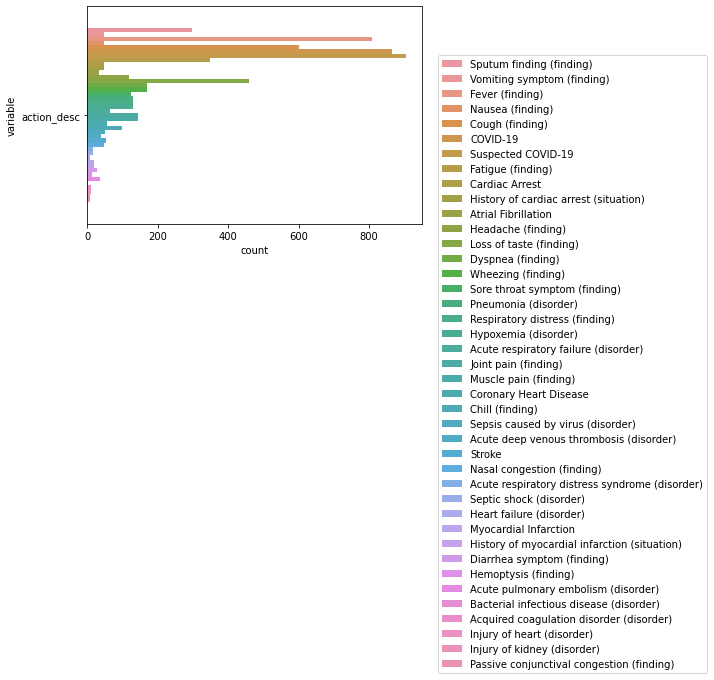

In [402]:
#Grafik Verteilung der Symptome
df_dwh_con = pd.read_sql_query("SELECT * FROM tb_encounters WHERE action_src = 'con'", conn_dwh)
sns.countplot(y="variable", hue= "value", data=pd.melt(df_dwh_con[["action_desc"]]))
plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), ncol=1)
plt.savefig(image_path+'Histogramm_Symptomverteilung.png')
plt.show()

In [403]:
#Grafik Anzahl Symptome pro Patient (gestaffelt)
#todo

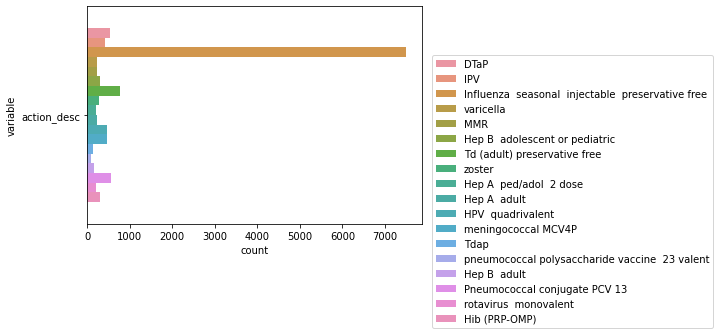

In [404]:
#Grafik Verteilung der Impfungen
df_dwh_con = pd.read_sql_query("SELECT * FROM tb_encounters WHERE action_src = 'imm'", conn_dwh)
sns.countplot(y="variable", hue= "value", data=pd.melt(df_dwh_con[["action_desc"]]))
plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), ncol=1)
plt.savefig(image_path+'Histogramm_Impfungsverteilung.png')
plt.show()

In [405]:
#Übersicht Codes Tabelle
df_dwh_pat = pd.read_sql_query("SELECT * FROM tb_codes ORDER BY action_code", conn_dwh)
df_dwh_pat.info()
df_dwh_pat

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   action_code  59 non-null     object
 1   action_desc  59 non-null     object
dtypes: object(2)
memory usage: 1.0+ KB


action_code                                        action_desc
0                10                                                IPV
1               113                       Td (adult) preservative free
2               114                                meningococcal MCV4P
3               115                                               Tdap
4               119                              rotavirus  monovalent
5               121                                             zoster
6   132281000119108            Acute deep venous thrombosis (disorder)
7               133                      Pneumococcal conjugate PCV 13
8               140  Influenza  seasonal  injectable  preservative ...
9                20                                               DTaP
10               21                                          varicella
11         22298006                              Myocardial Infarction
12        230690007                                             Stroke
13        233604007                               Pneumonia (disorder)
14        234466008           Acquired coagulation disorder (disorder)
15        246677007          Passive conjunctival congestion (finding)
16        248595008                           Sputum finding (finding)
17        249497008                         Vomiting symptom (finding)
18         25064002                                 Headache (finding)
19        267036007                                  Dyspnea (finding)
20        267060006                         Diarrhea symptom (finding)
21        267102003                      Sore throat symptom (finding)
22        271825005                     Respiratory distress (finding)
23                3                                                MMR
24               33     pneumococcal polysaccharide vaccine  23 valent
25         36955009                            Loss of taste (finding)
26        386661006                                    Fever (finding)
27        389087006                               Hypoxemia (disorder)
28        399211009       History of myocardial infarction (situation)
29         40095003                        Injury of kidney (disorder)
30        410429000                                     Cardiac Arrest
31        422587007                                   Nausea (finding)
32        429007001              History of cardiac arrest (situation)
33               43                                       Hep B  adult
34         43724002                                    Chill (finding)
35               49                                      Hib (PRP-OMP)
36         49436004                                Atrial Fibrillation
37         49727002                                    Cough (finding)
38               52                                       Hep A  adult
39         53741008                             Coronary Heart Disease
40         56018004                                 Wheezing (finding)
41         57676002                               Joint pain (finding)
42               62                                  HPV  quadrivalent
43         65710008               Acute respiratory failure (disorder)
44         66857006                               Hemoptysis (finding)
45         67782005     Acute respiratory distress syndrome (disorder)
46         68235000                         Nasal congestion (finding)
47         68962001                              Muscle pain (finding)
48        706870000                Acute pulmonary embolism (disorder)
49         76571007                            Septic shock (disorder)
50        770349000                  Sepsis caused by virus (disorder)
51                8                     Hep B  adolescent or pediatric
52               83                            Hep A  ped/adol  2 dose
53        840539006                                           COVID-19
54        840544004                                 Suspected COVID-19
55         84114007             

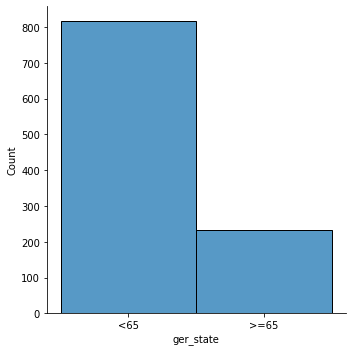

Anzahl nicht-geriatrischen Patienten (<65) zu geriatrischer Patienten (>=65)


In [406]:
# Hypothesen

#
# Geriatrische Patienten (65+) erkranken häufiger an Covid-19.
#

#Grafik Anzahl geriatrischer Patienten (>=65) zu nicht-geriatrischen Patienten (<65)
df_dwh_hyp1_1 = pd.read_sql_query(
    """
    SELECT DISTINCT pat.Id, pat.age
    FROM tb_patients as pat
    """
    , conn_dwh)

df_dwh_hyp1_1['ger_state'] = [">=65" if x >=65 else "<65" for x in df_dwh_hyp1_1['age']] #Umwandlung der Spalte Alter in feste Dimensionen [>=65] und [<65]

sns.displot(df_dwh_hyp1_1["ger_state"])
plt.savefig(image_path+'Histogramm_geriatrischer_Zustand.png')
plt.show()
print("Anzahl nicht-geriatrischen Patienten (<65) zu geriatrischer Patienten (>=65)")

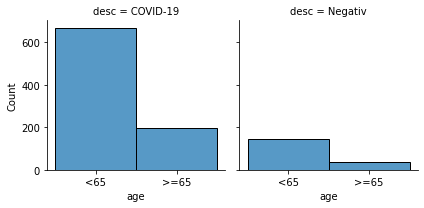

Anzahl nicht-geriatrischen Patienten (<65) zu geriatrischer Patienten (>=65), Links für Covid-19-positive Fälle. Rechts für negative Fälle


In [407]:
#Abfrage aller Patienten mit Alter und Covid-19-Status ('COVID-19' wenn positiv, '' wenn negativ)
df_dwh_hyp1_2 = pd.read_sql_query(
    """
    SELECT DISTINCT(temp.patient), pat.age, temp.desc

    FROM (
      SELECT enc.patient as patient, action_desc as desc
      FROM tb_encounters as enc
      WHERE action_code = '840539006'

      UNION

      SELECT Id, '' as action_desc
      FROM tb_patients
    ) as temp JOIN tb_patients as pat ON pat.Id = temp.patient 
    GROUP BY patient
    """
    , conn_dwh)

df_dwh_hyp1_2["desc"] = df_dwh_hyp1_2["desc"].replace([''], 'Negativ') #Ersetzen von leerem String '' mit dem String 'Negativ'
df_dwh_hyp1_2['age'] = [">=65" if x >=65 else "<65" for x in df_dwh_hyp1_2['age']] #Umwandlung der Spalte Alter in feste Dimensionen [>=65] und [<65]

g = sns.FacetGrid(df_dwh_hyp1_2, col="desc")
g.map(sns.histplot, "age")
plt.savefig(image_path+'Histogramm_geriatrischer_Zustand.png')
plt.show()
print("Anzahl nicht-geriatrischen Patienten (<65) zu geriatrischer Patienten (>=65), Links für Covid-19-positive Fälle. Rechts für negative Fälle")